# T1 Timing Only

This notebook was orignally developed just to look at T1 resets using very simple vairables. Currently, its purpose is to process high stats data to get a small number of fundamental parameters.

In [5]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os
import glob
import pickle as pkl

CRT_Wall_Dict = {
       "South": 1,
       "North": 2,
       "West": 3,
       "East": 4,
       "Bottom": 0,
       "Top Low": 5,
       "Top High": 6
       }

CRT_Wall_Arr = ["Bottom", "South", "North", "West", "East", "Top Low", "Top High"]

In [6]:
def list_matching_files(folder_path, pattern):
    search_pattern = os.path.join(folder_path, pattern)
    files = glob.glob(search_pattern)
    return [f for f in files if os.path.isfile(f)]

# path = "/exp/sbnd/data/users/jbateman/workdir/crt/run/"
path ="/pnfs/sbnd/persistent/users/jbateman/crt/run/"

run=  "017985" # "013693" , "018002" 
folder_path = path+run

# matching_files = list_matching_files(folder_path, "crtana_data_*")
matching_files = list_matching_files(folder_path, "crt_ana_*")

# Check how many files there are - memory gets upset if you try load too many
# Because we're looking at so few features, we can afford to just import everything in one go!

batch_number = 0
batch_size = 15
# Theres probably a better way to loop this, but this is good enough for now!
print("Total batches = ", int(np.ceil(len(matching_files)/batch_size)))
matching_files = matching_files[batch_number*batch_size:(batch_number+1)*batch_size]

Total batches =  12


In [11]:
## Using a very reduced number of features, as we don't have RWM/ETrig to make more complex figures

# For runs w/o flash trigger, know what each TDC timestamp is!
# ['crtt1' 'bes' 'etrig' 'ftrig' 'rwm']
rwm_index = 4
etrig_index = 2

features = ["feb_ts0", "feb_ts1", "feb_flags","tdc_timestamp"]

# Load the first file to get the columns
ttree = uproot.open(matching_files[0])
print("Loading ", matching_files[0], "...")

recodata = ttree['crtana/tree'].arrays(features, library='ak')
# recodata = ttree['crtana/tree'].arrays(library='ak')

# Merge all the files into one dataframe
for file in matching_files[1:]:
    print("Loading ", file, "...")
    ttree = uproot.open(file)

    temp_recodata = ttree['crtana/tree'].arrays(features, library='ak')
    # temp_recodata = ttree['crtana/tree'].arrays(library='ak')

    recodata = ak.concatenate([recodata, temp_recodata])
    ttree.close()

Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_aa.root ...


Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ab.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ac.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ad.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ae.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_af.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ag.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ah.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ai.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_aj.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_ak.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_al.root ...
Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_am.root ...
Loading  /pnfs/sbnd/persiste

Text(0.5, 0, '(feb_ts1 | Flag == 3) (ms)')

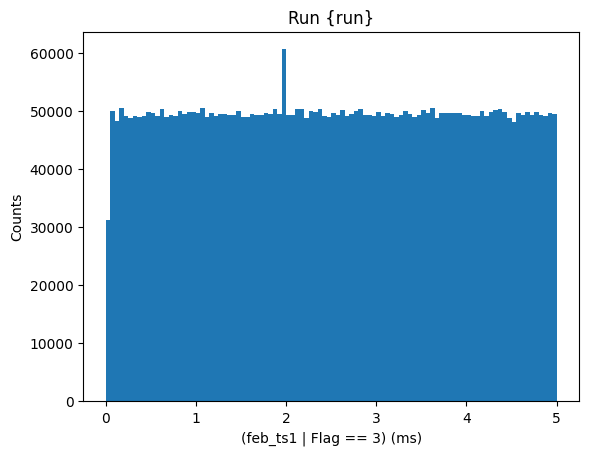

In [14]:
filter_ts1 = recodata["feb_ts1"][recodata.feb_flags == 3]

plt.hist(ak.flatten(filter_ts1)/1e6, range=(0,5), bins = 100)
# plt.yscale('log')
plt.title('Run {run}')
plt.ylabel('Counts')
plt.xlabel('(feb_ts1 | Flag == 3) (ms)')

Text(0.5, 0, '(feb_ts1 | Flag == 3) (ms)')

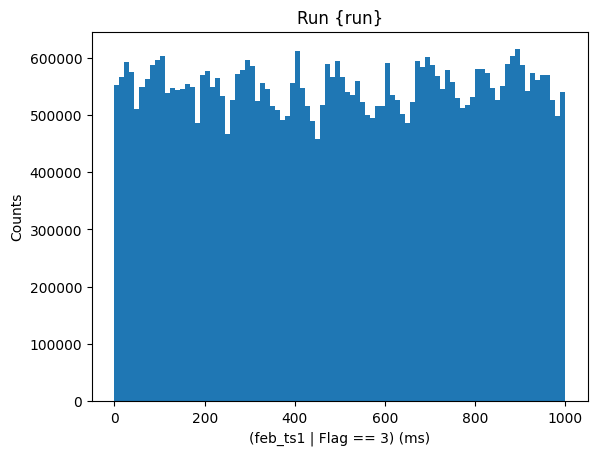

In [15]:
filter_ts0 = recodata["feb_ts0"][recodata.feb_flags == 3] 

plt.hist(ak.flatten(filter_ts0)/1e6, range=(0,1000), bins = 90)
# plt.yscale('log')
plt.title('Run {run}')
plt.ylabel('Counts')
plt.xlabel('(feb_ts1 | Flag == 3) (ms)')

In [16]:
# Extract the relevant columns
tdc_timestamps = recodata['tdc_timestamp']
feb_ts0 = recodata['feb_ts0']

# Filter rows where tdc_timestamps has length 5
mask = ak.num(tdc_timestamps) == 5

# Extract the relevant tdc and ts0 values
tdc_filtered = np.int64(tdc_timestamps[mask][:, rwm_index]) % 10**9
ts0_filtered = feb_ts0[mask]

# Adjust ts0 values
ts0_adjusted = ak.to_numpy(ak.flatten(ts0_filtered - tdc_filtered[:, np.newaxis])) / 1e3 + 1 # Convert to microseconds 

In [17]:
ts0_adjusted_scaled = np.where(ts0_adjusted > 500000, ts0_adjusted - 1000000, ts0_adjusted)

Text(0.5, 0, '(TS0 - RWM | Flag == 3) (us)')

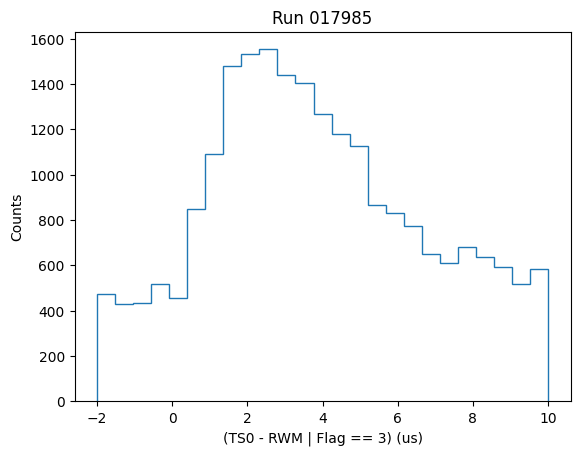

In [21]:
plt.hist(ts0_adjusted_scaled+1, histtype='step', range=(-2,10), bins = 25)
# plt.yscale('log')
plt.title(f'Run {run}')
plt.ylabel('Counts')
plt.xlabel('(TS0 - RWM | Flag == 3) (us)')